# explore the extended kalman filter data

````
Data Flow:
1) The measuremennt processor/matlab simulator is generating the FUSION .txt file:
	"data/obj_pose-laser-radar-synthetic-ukf-input.txt";
	OR
	"../matlab_examples/obj_pose-laser-radar-synthetic-ukf-input.txt";

The Input file format is:
#L(for laser) meas_px meas_py timestamp gt_px gt_py gt_vx gt_vy
#R(for radar) meas_rho meas_phi meas_rho_dot timestamp gt_px gt_py gt_vx gt_vy

Example:
R	8.60363	0.0290616	-2.99903	1477010443399637	8.6	0.25	-3.00029	0
L	8.45	0.25	1477010443349642	8.45	0.25	-3.00027	0
	
2) The EKF Algorithm reads form file reads all the lines and generates measurement structures
3) The MeasurementProcessor() is called with individual measurements (one by one). The results are saved
(Attention: no file processing routines are used inside MeasurementProcessor() all the file processing routines are in the main function
So the data read/write is decoupled from the algorithm
4) The results are saved in an output file:
"data/obj_pose-laser-radar-ekf-output.txt"

Output file format:
est_px est_py est_vx est_vy meas_px meas_py gt_px gt_py gt_vx gt_vy

Example:
4.53271	0.279	-0.842172	53.1339	4.29136	0.215312	2.28434	0.226323
43.2222	2.65959	0.931181	23.2469	4.29136	0.215312	2.28434	0.226323
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
import math
import random
import csv

%matplotlib inline

In [2]:
raw_data = []
with open('data/obj_pose-laser-radar-synthetic-input.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        raw_data.append(row)

In [3]:
def polar_to_cartesian(polar_x):
    rho, phi, drho = polar_x[0], polar_x[1], polar_x[2]
    
    px = rho * math.cos(phi)
    py = rho * math.sin(phi)
    vx = drho * math.cos(phi)
    vy = drho * math.sin(phi)
    
    return np.array([px, py, vx, vy])
    

In [4]:
def cartesian_to_polar(cartesian_x_):
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    
    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

In [5]:
def get_jacobian_from_state(cartesian_x_):
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    
    
    px2_plus_py2 = px**2 + py**2
    on_sqrt = math.sqrt(px2_plus_py2)
    on_3_per_2 = math.pow(px2_plus_py2, 3/2)
    
    vi1 = py * (vx*py - vy*px) / on_3_per_2
    vi2 = px * (vy*px - vx*py) / on_3_per_2
    
    Hj = np.array([[px / on_sqrt,        py / on_sqrt,      0,             0]
                  ,[-py / px2_plus_py2,  px / px2_plus_py2, 0,             0]
                  ,[vi1,                 vi2,               px / on_sqrt,  py / on_sqrt ]
                  ])
    return Hj
    
    

In [163]:
class Kalman():
    def __init__(self):
        self.x = np.array([[0], 
                           [0],
                           [0],
                           [0]]) # initial state (location and velocity)
        self.reset()
        
    def reset(self):
        self.P = np.array([[1000., 0., 0., 0.], 
                           [0., 1000., 0., 0.],
                           [0., 0., 1000., 0.],
                           [0., 0., 0., 1000.]]) # initial uncertainty
        
        self.u = np.array([[0], [0], [0], [0]]) # external motion
        
        self.F = np.array([[1, 0, 1, 0], 
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # next state function
        
        self.H = np.array([[1, 0, 0, 0] # X to measurement mapping matrix (H * x = measurement)
                          ,[0, 1, 0, 0]])
        
        self.R = np.array([[1, 0 ]
                           ,[0, 1]]) # measurement uncertainty

        self.R_R = np.array([[1, 0, 0 ]
                            ,[0, 1, 0]
                            ,[0, 0, 1]]) # measurement uncertainty        
        
        self.I = np.array([[1, 0, 0, 0], 
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # identity matrix      
        
    def feed_meas_L(self, measurement, dt):
         
        z = np.array(measurement).reshape((2,-1)) # z - measurement matrix

        # dt into the state transition matrix
        self.F[0, 2] = dt;
        self.F[1, 3] = dt;
    
        y = z - np.dot(self.H, self.x) # error : previous state - measurement X measurement matrix

        #print ('y', y)
        S = np.dot(np.dot(self.H, self.P), self.H.transpose()) + self.R
        K = np.dot(np.dot(self.P, self.H.transpose()), np.linalg.inv(S)) # kalman gain

        
        ##### covariance uncertainity Q
        ##### values coming from decomposing the acceleration component in the kin.equatations
        #####################
        
        
        axsig = 0.001
        aysig = 0.001
        dt4_per_4 = dt**4/4
        dt3_per_2 = dt**3/2
        dt2 = dt**2
        
        Q = np.array([[dt4_per_4*axsig, 0, dt3_per_2*axsig, 0]
                    ,[0, dt4_per_4*aysig, 0, dt3_per_2*aysig]
                    ,[dt3_per_2*axsig, 0, dt2*axsig, 0]
                    ,[0, dt3_per_2*aysig, 0, dt2*aysig]]
                    );
                
        
        #print ('K', K)
        self.x = self.x + np.dot(K, y) # new state : x + kalman gain X error
        self.P = np.dot((self.I - np.dot(K, self.H)), self.P) + Q # adjusting uncertainty covariance

    def feed_meas_R(self, measurement, dt):
         
        z = np.array(measurement).reshape((3,-1)) # z - measurement matrix; this is radar, so 3 pieces

        # dt into the state transition matrix
        self.F[0, 2] = dt;
        self.F[1, 3] = dt;
    
        Hx = cartesian_to_polar(self.x).reshape(3,-1)
        y = z - Hx # error : previous state - current state converted to polar

        # instead of H using jacobian
        Hj = get_jacobian_from_state(self.x.reshape(1, -1))
        
        S = np.dot(np.dot(Hj, self.P), self.H.transpose()) + self.R_R
        K = np.dot(np.dot(self.P, Hj.transpose()), np.linalg.inv(S)) # kalman gain

        
        ##### covariance uncertainity Q
        ##### values coming from decomposing the acceleration component in the kin.equatations
        #####################
        
        
        axsig = 0.001
        aysig = 0.001
        dt4_per_4 = dt**4/4
        dt3_per_2 = dt**3/2
        dt2 = dt**2
        
        Q = np.array([[dt4_per_4*axsig, 0, dt3_per_2*axsig, 0]
                    ,[0, dt4_per_4*aysig, 0, dt3_per_2*aysig]
                    ,[dt3_per_2*axsig, 0, dt2*axsig, 0]
                    ,[0, dt3_per_2*aysig, 0, dt2*aysig]]
                    );
                
        
        #print ('K', K)
        self.x = self.x + np.dot(K, y) # new state : x + kalman gain X error
        self.P = np.dot((self.I - np.dot(K, self.H)), self.P) + Q # adjusting uncertainty covariance
    
    def predict_next_state(self):
        
        
        #print ('F', self.F)
        #print ('x', self.x)
        
        self.x = np.dot(self.F, self.x) + self.u # new state : movement matrix X current state + movement
        self.P = np.dot(np.dot(self.F, self.P), self.F.transpose()) # adjusting covar matrix 

In [164]:
pred_list = []
l_meas_list = []
r_meas_list = []

k = Kalman()
timestamp = 0
for p in raw_data:
    if p[0] == 'L':
        ## lidar
        x, y = float(p[1]), float(p[2])
        dt = int(p[3]) - timestamp
        timestamp = int(p[3])
        #print("L", dt, x, y)
        k.feed_meas_L([x,y], dt)
        k.predict_next_state()
        
        l_meas_list.append([x,y])
        pred_list.append(k.x)
    else:
        rho, phi, drho = float(p[1]), float(p[2]), float(p[3])
        dt = int(p[4]) - timestamp
        timestamp = int(p[4])
        
        k.feed_meas_R([rho, phi, drho], dt)
        k.predict_next_state()
        
        r_meas_list.append(polar_to_cartesian([rho, phi, drho]))
        
        

pred_list = np.array(pred_list)
l_meas_list = np.array(l_meas_list)
r_meas_list = np.array(r_meas_list)



ValueError: operands could not be broadcast together with shapes (3,2) (3,3) 

In [162]:
plt.figure(figsize=(20,20))
plt.scatter(l_meas_list[:,0], l_meas_list[:,1])
plt.scatter(r_meas_list[:,0], r_meas_list[:,1])

plt.scatter(pred_list[:,0], pred_list[:,1])

TypeError: list indices must be integers or slices, not tuple

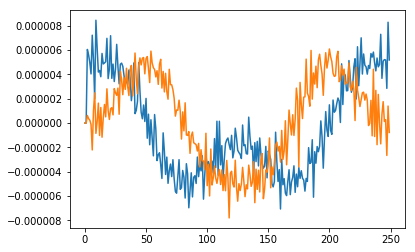

In [8]:
plt.plot(pred_list[:,2])
plt.plot(pred_list[:,3])

In [9]:
r_data = my_data = [x for x in raw_data if x[0] == 'R']
rr = np.array(r_data)[:,1:4].astype(float)

In [46]:
cart_rr = np.array([polar_to_cartesian(r) for r in rr])

In [87]:
pred_list = []
k = Kalman()
for i in range(len(rr)):
    k.feed_meas_R(rr[i], dt_list[i])
    k.predict_next_state()
    pred_list.append(k.x)
pred_list = np.array(pred_list).reshape((-1,4))

IndexError: index 1 is out of bounds for axis 0 with size 1

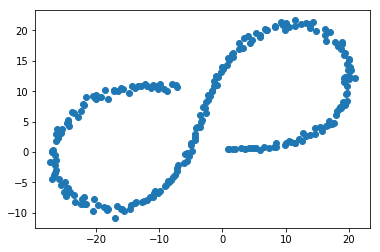

In [49]:
plt.scatter(cart_rr[:,0], cart_rr[:,1])